In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.4 MB/s 
     |████████████████████████████████| 7.6 MB 56.2 MB/s 
     |████████████████████████████████| 182 kB 30.4 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [5]:
# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/AIVLE/bigProject/train_x_final.csv', encoding='cp949')
data.head()

,reviews,price,drink,dessert,service,customers,interior,view,parking,trash
0,만족도 최상의 커피 맛집,0,1,0,0,0,0,0,0,0
1,찐 커피 맛집,0,1,0,0,0,0,0,0,0
2,로마노 진짜 달달하고 맛있고,0,1,0,0,0,0,0,0,0
3,아이스크림 라떼도 꼬소하고 달달하고 진짜 맛있어요!!,0,1,0,0,0,0,0,0,0
4,마리토쪼도 크림 부드럽고,0,0,1,0,0,0,0,0,0


In [6]:
train_data, test_data = train_test_split(data, test_size=.2)

print('훈련용 리뷰 개수 :', len(train_data))
print('테스트용 리뷰 개수 :', len(test_data))

훈련용 리뷰 개수 : 7503
테스트용 리뷰 개수 : 1876


---

In [7]:
# GPU 환경 설정
# assert tf.test.is_gpu_available() == True, 'GPU 설정을 확인하세요.'
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [8]:
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [9]:
def create_examples(df):
    example = []
    label = []
    for (i, row) in enumerate(df.values):
        example.append(row[0])
        label.append(row[1:])
    
    return example, label

In [10]:
train_example, train_label = create_examples(train_data)
test_example, test_label = create_examples(test_data)

In [11]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):
    
    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []
    
    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [12]:
max_seq_len = 128

In [13]:
train_X, train_y = convert_examples_to_features(train_example, train_label, max_seq_len=max_seq_len, tokenizer=tokenizer)
test_X, test_y = convert_examples_to_features(test_example, test_label, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/7503 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1876/1876 [00:00<00:00, 4952.75it/s]


In [14]:
base_model = TFBertModel.from_pretrained("klue/bert-base", from_pt=True)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [15]:
input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
token_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

x = base_model.bert([input_ids, attention_mask, token_type_ids])[1]
outputs = tf.keras.layers.Dense(9, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02), activation='sigmoid', name='classifier')(x)

In [16]:
model = tf.keras.models.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [17]:
model.fit(train_X, train_y, epochs=3, batch_size=16, validation_split=0.2) 

Epoch 1/3
376/376 [==============================] - 189s 461ms/step - loss: 0.1950 - accuracy: 0.6381 - val_loss: 0.1295 - val_accuracy: 0.7368
Epoch 2/3
376/376 [==============================] - 167s 445ms/step - loss: 0.1093 - accuracy: 0.7834 - val_loss: 0.1161 - val_accuracy: 0.7595
Epoch 3/3
376/376 [==============================] - 166s 442ms/step - loss: 0.0845 - accuracy: 0.8209 - val_loss: 0.1176 - val_accuracy: 0.7528


In [18]:
model.save("/content/drive/MyDrive/AIVLE/bigProject/myModel")

In [19]:
mymodel = tf.keras.models.load_model("/content/drive/MyDrive/AIVLE/bigProject/myModel")

In [20]:
pred = mymodel.predict(test_X, batch_size=8)

235/235 [==============================] - 23s 84ms/step


In [21]:
pred = np.where(pred>0.5, 1, 0)

In [22]:
keywords = ['price', 'drink', 'dessert', 'service', 'customers', 'interior', 'view', 'parking', 'trash']
print(classification_report(test_y, pred, output_dict=False, target_names=keywords))

              precision    recall  f1-score   support

       price       0.81      0.86      0.83        49
       drink       0.90      0.82      0.86       334
     dessert       0.90      0.89      0.89       536
     service       0.92      0.64      0.75       185
   customers       0.78      0.78      0.78        80
    interior       0.78      0.88      0.82       255
        view       0.86      0.85      0.85       229
     parking       1.00      0.87      0.93        39
       trash       0.67      0.66      0.66       290

   micro avg       0.84      0.81      0.82      1997
   macro avg       0.85      0.80      0.82      1997
weighted avg       0.84      0.81      0.82      1997
 samples avg       0.79      0.79      0.78      1997



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
cm = multilabel_confusion_matrix(test_y, pred)

In [24]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

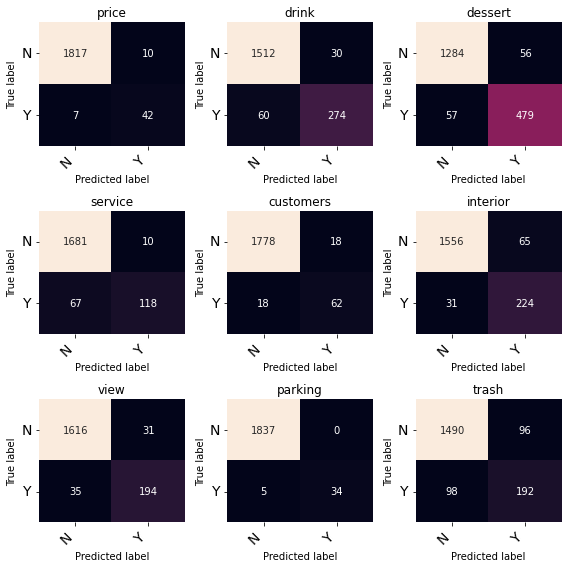

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    
for axes, cfs_matrix, label in zip(ax.flatten(), cm, keywords):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])

fig.tight_layout()
plt.show()